In [9]:
import tkinter as tk
from tkinter import ttk , scrolledtext
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg



In [10]:
# Benchmark functions
def ackley(xx, a=20, b=0.2, c=2*np.pi):
    d = len(xx)
    sum1 = np.sum(np.square(xx))
    sum2 = np.sum(np.cos(c * np.array(xx)))
    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)
    y = term1 + term2 + a + np.exp(1)
    return y

def bukin6(xx):
    x1, x2 = xx
    term1 = 100 * np.sqrt(np.abs(x2 - 0.01 * x1 ** 2))
    term2 = 0.01 * np.abs(x1 + 10)
    y = term1 + term2
    return y

def crossit(xx):
    x1, x2 = xx
    fact1 = np.sin(x1) * np.sin(x2)
    fact2 = np.exp(np.abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))
    y = -0.0001 * (np.abs(fact1 * fact2) + 1) ** 0.1
    return y

def drop(xx):
    x1, x2 = xx
    frac1 = 1 + np.cos(12 * np.sqrt(x1 ** 2 + x2 ** 2))
    frac2 = 0.5 * (x1 ** 2 + x2 ** 2) + 2
    y = -frac1 / frac2
    return y

def egg(xx):
    x1, x2 = xx
    term1 = -(x2 + 47) * np.sin(np.sqrt(np.abs(x2 + x1 / 2 + 47)))
    term2 = -x1 * np.sin(np.sqrt(np.abs(x1 - (x2 + 47))))
    y = term1 + term2
    return y

In [20]:
class GeneticAlgorithm:
    def __init__(self, objective_function, pop_size=400, n_gen=1000, crossover_rate=0.8, mutation_rate=0.2):
        self.objective_function = objective_function
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.fitness_history = []  # Store fitness history
        self.avg_fitness_history = []  # Store average fitness history
        self.population = None  # Initialize population attribute

    # Random initialization
    def initialize_population(self, dim):
        return np.random.uniform(-10, 10, size=(self.pop_size, dim))
    
    # Initialization from previous knowledge
    def initialize_population_previous(self, dim, previous_population):
        # Use the final population from the previous run
        return np.copy(previous_population)

    def constraint_handling(self, population):
        # Constraint handling using penalty method
        for individual in population:
            penalty = self.constraint_penalty(individual)
            individual_fitness = self.objective_function(individual)
            individual_fitness += penalty

    def constraint_penalty(self, individual):
        penalty = 0
        for gene in individual:
            if gene < -10 or gene > 10:  # Assuming the range of genes is [-10, 10]
                penalty += 1000  # Penalty for violating constraints
        return penalty

    def tournament_selection(self, population, fitness):
        selected_parents = []
        for _ in range(self.pop_size):
            tournament_indices = np.random.choice(len(population), size=self.tournament_size, replace=False)
            tournament_fitness = fitness[tournament_indices]
            winner_index = tournament_indices[np.argmax(tournament_fitness)]
            selected_parents.append(population[winner_index])
        return np.array(selected_parents)
    
    def roulette_wheel_selection(self, population, fitness): # Calculates selection probabilities based on the fitness values of individuals
        # Ensure non-negativity of fitness values
        fitness = np.abs(fitness)
        total_fitness = np.sum(fitness)
        selection_probabilities = fitness / total_fitness
        # randomly select indices from the range of indices corresponding to the population size.
        selected_indices = np.random.choice(len(population), size=self.pop_size, replace=True, p=selection_probabilities)
        selected_parents = population[selected_indices]
        return selected_parents

    def crossover_single_point(self, parents):
        children = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i+1]
            if np.random.rand() < self.crossover_rate:
                crossover_point = np.random.randint(1, len(parent1))
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1, child2 = parent1, parent2
            children.append(child1)
            children.append(child2)
        return np.array(children)

    def crossover_multiple_point(self, parents):
        children = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i+1]
            if np.random.rand() < self.crossover_rate:
                crossover_points = sorted(np.random.choice(len(parent1), size=2, replace=False))
                child1 = np.concatenate((parent1[:crossover_points[0]], parent2[crossover_points[0]:crossover_points[1]], parent1[crossover_points[1]:]))
                child2 = np.concatenate((parent2[:crossover_points[0]], parent1[crossover_points[0]:crossover_points[1]], parent2[crossover_points[1]:]))
            else:
                child1, child2 = parent1, parent2
            children.append(child1)
            children.append(child2)
        return np.array(children)

    def mutation_uniform(self, population):
        mutated_population = population + np.random.normal(0, 0.1, size=population.shape)
        return mutated_population
    #select a substring and then shuffle it
    def mutation_scramble(self, population):
        mutated_population = []
        for individual in population:
            idx1, idx2 = np.random.choice(len(individual), size=2, replace=False)
            start_idx, end_idx = min(idx1, idx2), max(idx1, idx2)
            scrambled_genes = np.random.permutation(individual[start_idx:end_idx])
            individual[start_idx:end_idx] = scrambled_genes
            mutated_population.append(individual)
        return np.array(mutated_population)
    # 1/population size  removing worst
    def steady_state_replacement(self, population, offspring):
        replace_idx = np.random.randint(len(population))
        population[replace_idx] = offspring
        return population
    # Adjusts the mutation rate and crossover rate based on the current generation and the total number of generations.
    def adapt_parameters(self, generation, max_generations):
        self.mutation_rate = max(0.1, 1 - generation / max_generations)
        self.crossover_rate = min(0.9, generation / max_generations)

    def crowding(self, population, offspring):
        # Calculate Euclidean distances between each pair of individuals
        distances = np.linalg.norm(population[:, np.newaxis, :] - offspring[np.newaxis, :, :], axis=2)
        # Check if any offspring is closer to a population member than a threshold
        min_distances = np.min(distances, axis=0)
        replace_indices = np.where(min_distances < 0.1)[0]  # Example threshold
        # Replace population members with new offspring
        if len(replace_indices) > 0:
            replace_idx = np.random.choice(replace_indices)
            population[replace_idx] = offspring[replace_idx]
        return population

    def evolve(self, dim, previous_population=None):
        if previous_population is not None:
            self.population = self.initialize_population_previous(dim, previous_population)
        else:
            self.population = self.initialize_population(dim)
        for gen in range(self.n_gen):
            fitness = np.array([self.objective_function(ind) for ind in self.population])
            self.fitness_history.append(np.min(fitness))
            self.avg_fitness_history.append(np.mean(fitness))  # Store average fitness
            self.constraint_handling(self.population)
            self.adapt_parameters(gen, self.n_gen)
            selected_population = self.roulette_wheel_selection(self.population, fitness)
            children = self.crossover_single_point(selected_population)
            mutated_children = self.mutation_scramble(children)
            self.population = self.crowding(self.population, mutated_children)
        best_solution = self.population[np.argmin(fitness)]
        return best_solution, np.min(fitness), self.avg_fitness_history

In [21]:
class DifferentialEvolution:
    def __init__(self, objective_function, pop_size=100, n_gen=1000, mutation_factor=0.5, crossover_rate=0.7):
        self.objective_function = objective_function
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.fitness_history = []  # Store fitness history
        self.avg_fitness_history = []  # Store average fitness history
        self.population = None  # Initialize population attribute

    def initialize_population(self, dim):
        return np.random.uniform(-10, 10, size=(self.pop_size, dim))

    def mutation(self, population):
        # Mutation using DE/rand/1 strategy
        mutated_population = []
        for target in population:
            indices = np.random.choice(len(population), size=3, replace=False)
            r1, r2, r3 = population[indices]
            donor = r1 + self.mutation_factor * (r2 - r3)
            mutated_individual = np.where(np.random.rand(len(target)) < self.crossover_rate, donor, target)
            mutated_population.append(mutated_individual)
        return np.array(mutated_population)

    def crossover(self, population, mutated_population):
        # Binomial crossover
        crossed_population = []
        for target, mutated in zip(population, mutated_population):
            crossover_points = np.random.rand(len(target)) < self.crossover_rate
            crossed_individual = np.where(crossover_points, mutated, target)
            crossed_population.append(crossed_individual)
        return np.array(crossed_population)
    
    '''
    As the generation progresses the mutation factor decreases linearly from 0.5 to 0.1. This reduction 
    ensures that the algorithm gradually reduces exploration and focuses more on exploitation towards the end of the optimization process.
    '''
    # to balance exploration and exploitation during the optimization process.
    def adapt_parameters(self, generation, max_generations):
        # Adapt mutation factor and crossover rate
        self.mutation_factor = max(0.1, 0.5 * (1 - generation / max_generations))
        self.crossover_rate = max(0.1, 0.9 * (1 - generation / max_generations))

    def evolve(self, dim, previous_population=None):
        if previous_population is not None:
            self.population = previous_population
        else:
            self.population = self.initialize_population(dim)
        for gen in range(self.n_gen):
            fitness = np.array([self.objective_function(ind) for ind in self.population])
            self.fitness_history.append(np.min(fitness))
            self.avg_fitness_history.append(np.mean(fitness))  # Store average fitness
            mutated_population = self.mutation(self.population)
            crossed_population = self.crossover(self.population, mutated_population)
            self.population = crossed_population
            self.adapt_parameters(gen, self.n_gen)
        best_solution = self.population[np.argmin(fitness)]
        return best_solution, np.min(fitness), self.avg_fitness_history

In [22]:
# Implementing output results
def print_results(algorithm_name, function_name, best_solution, fitness):
    print(f"{algorithm_name} Results for {function_name}:")
    print(f"Optimal Solution: {best_solution}")
    print(f"Fitness Value: {fitness}\n")

def plot_convergence(algorithm_name, fitness_history):
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, label=f"{algorithm_name} Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value")
    plt.title(f"{algorithm_name} Convergence Plot")
    plt.legend()    
    plt.grid(True)
    plt.show()


In [23]:
# Experiment loop
benchmark_functions = {
    "Ackley": ackley,
    "Bukin6": bukin6,
    "Cross-in-Tray": crossit,
    "Drop-Wave": drop,
    "Egg-Holder": egg
}

In [24]:
algorithms = {
    "Genetic Algorithm": GeneticAlgorithm,
    "Differential Evolution": DifferentialEvolution
}

## Testing

Running experiments for Ackley function:

Genetic Algorithm Results for Ackley:
Optimal Solution: [-0.99227838  0.5107979 ]
Fitness Value: 4.637837431617545



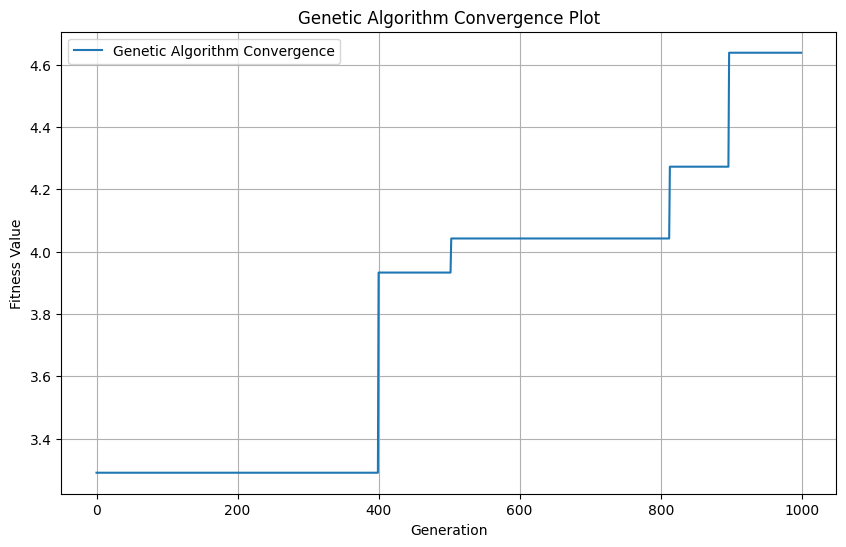

Differential Evolution Results for Ackley:
Optimal Solution: [-8.43806763e+15  1.00114105e+14]
Fitness Value: 20.046005228596233



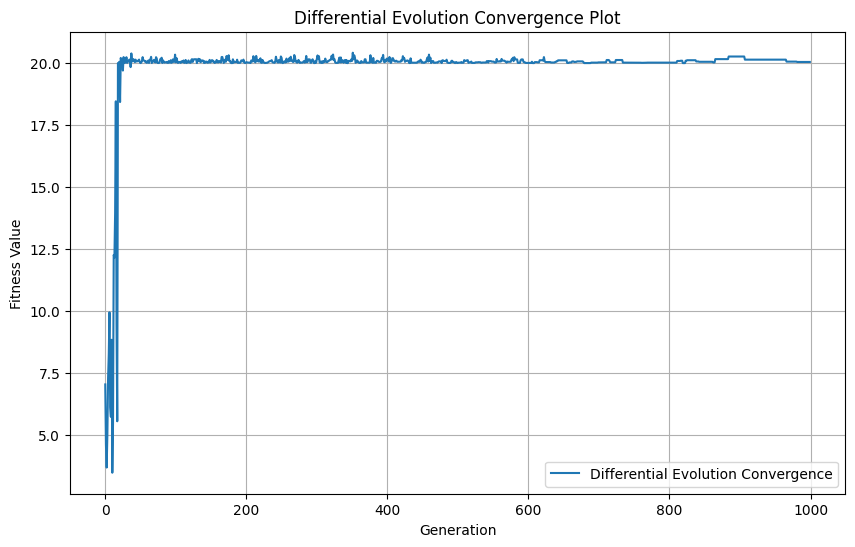

Running experiments for Bukin6 function:

Genetic Algorithm Results for Bukin6:
Optimal Solution: [-4.82147691  0.90150786]
Fitness Value: 81.84673985505063



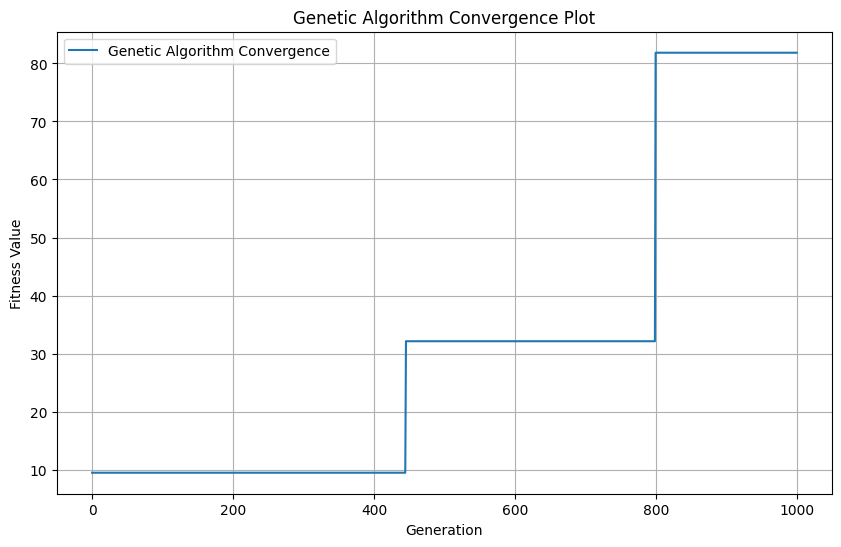

Differential Evolution Results for Bukin6:
Optimal Solution: [ 8.37495960e+13 -4.74404887e+15]
Fitness Value: 838333455598556.8



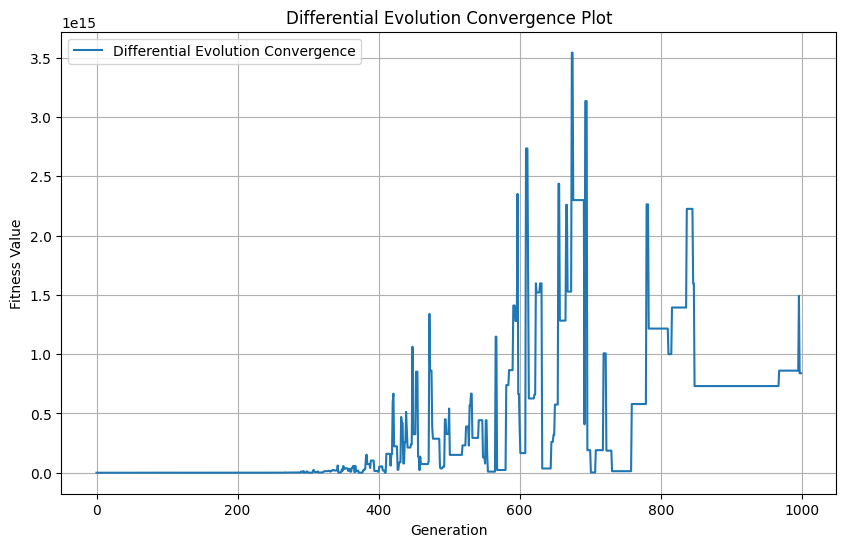

Running experiments for Cross-in-Tray function:

Genetic Algorithm Results for Cross-in-Tray:
Optimal Solution: [ 0.90555363 -1.26334227]
Fitness Value: -2.0368356209946765



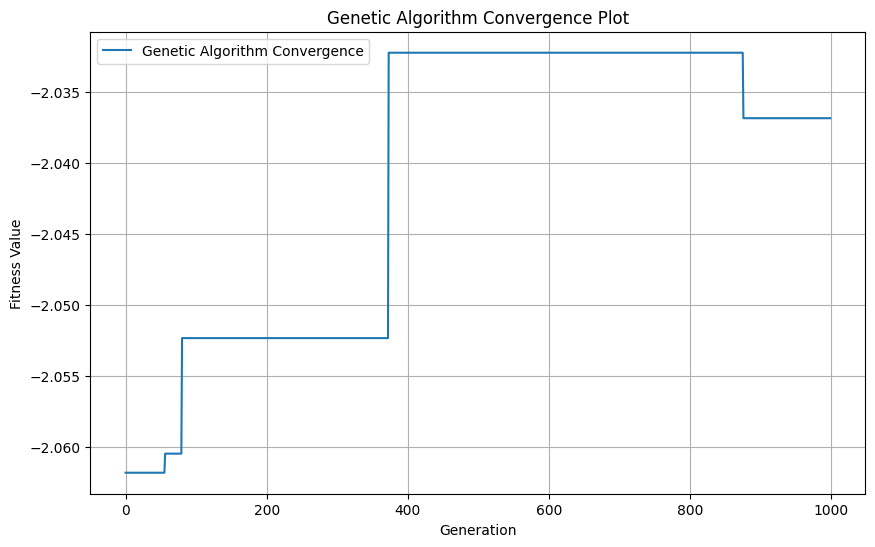

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6392\3369522576.py:21: RuntimeWarning: overflow encountered in exp
  fact2 = np.exp(np.abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))


Differential Evolution Results for Cross-in-Tray:
Optimal Solution: [8.99912526e+15 3.90282670e+14]
Fitness Value: -inf



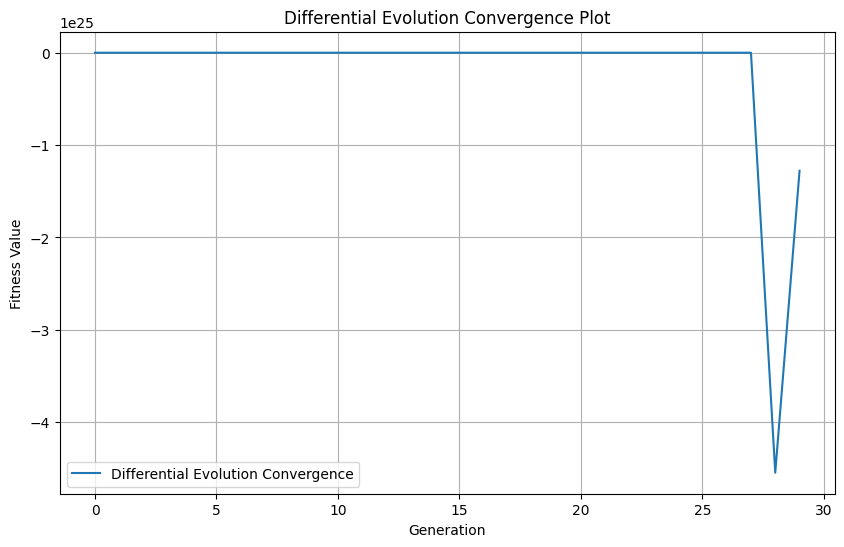

Running experiments for Drop-Wave function:

Genetic Algorithm Results for Drop-Wave:
Optimal Solution: [-0.0245189   0.43667964]
Fitness Value: -0.7208847299749123



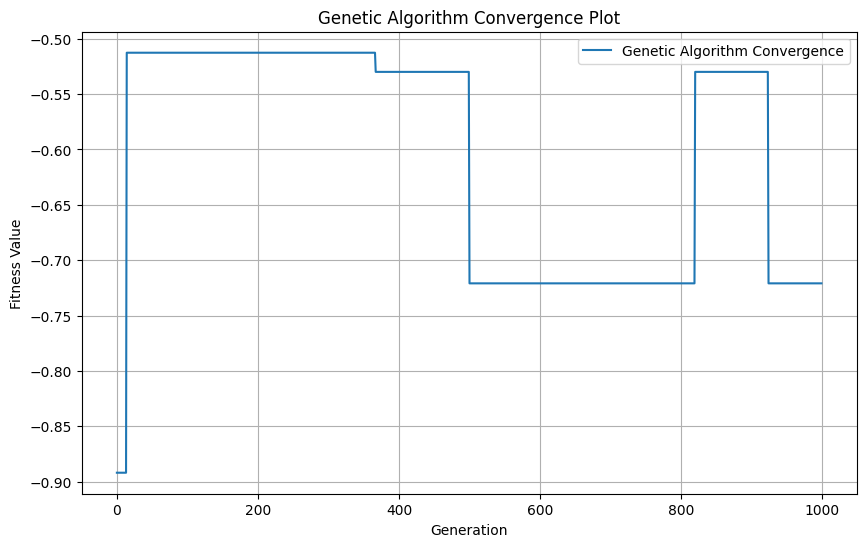

Differential Evolution Results for Drop-Wave:
Optimal Solution: [-1.69236372e+14 -1.52332650e+13]
Fitness Value: -1.3746335414218283e-28



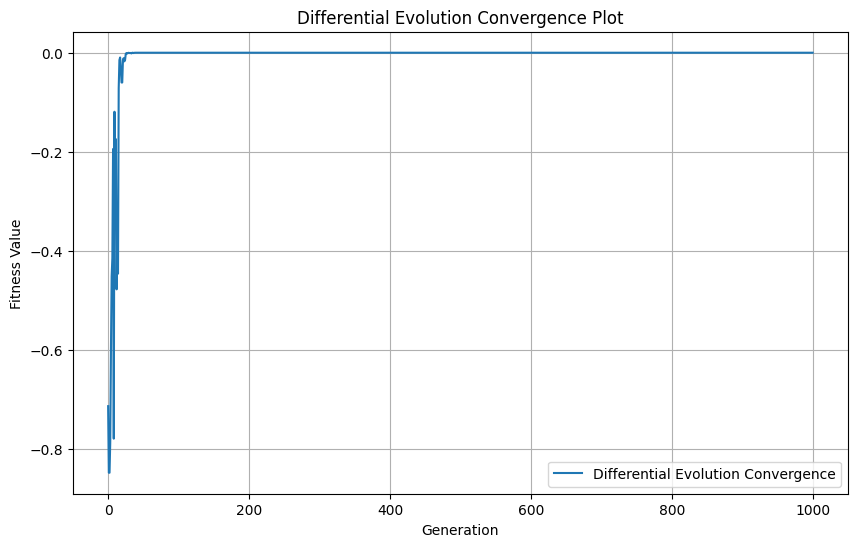

Running experiments for Egg-Holder function:

Genetic Algorithm Results for Egg-Holder:
Optimal Solution: [8.23482101 9.03176736]
Fitness Value: -60.61458594143899



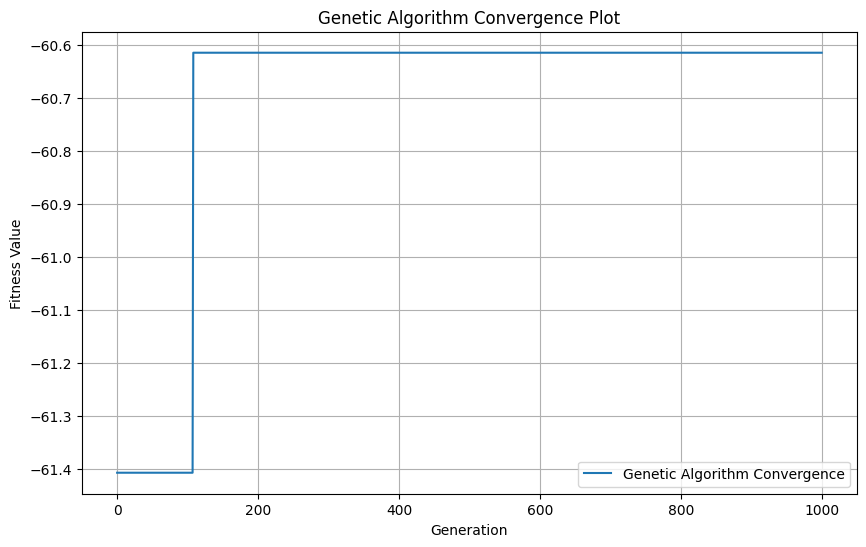

Differential Evolution Results for Egg-Holder:
Optimal Solution: [-5.17625617e+15  9.53388092e+15]
Fitness Value: -1.251163756329361e+16



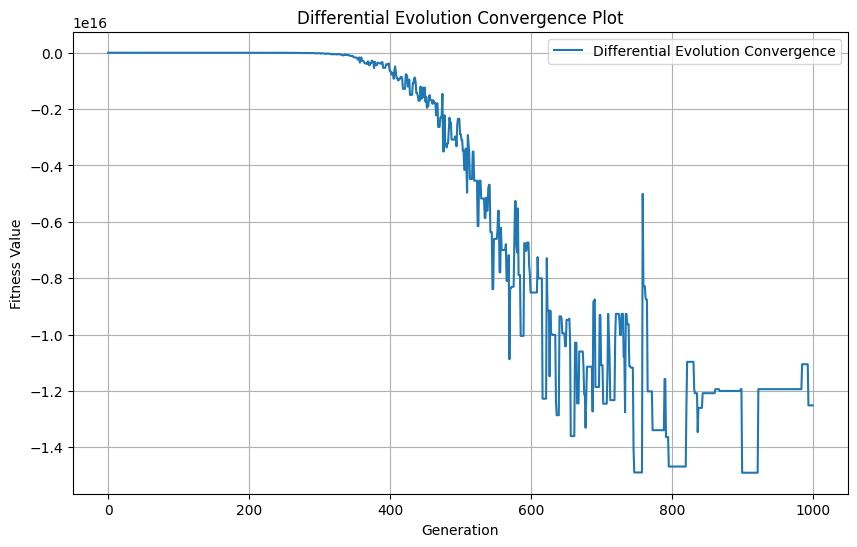

In [25]:
# Experiment loop
for function_name, objective_function in benchmark_functions.items():
    print(f"Running experiments for {function_name} function:\n")
    for algorithm_name, algorithm_class in algorithms.items():
        algorithm = algorithm_class(objective_function)
        best_solution, fitness, avg_fitness_history = algorithm.evolve(2)  # Assuming 2-dimensional optimization
        print_results(algorithm_name, function_name, best_solution, fitness)
        plot_convergence(algorithm_name, algorithm.fitness_history)

In [26]:
# Experiment loop
for function_name, objective_function in benchmark_functions.items():
    print(f"Running experiments for {function_name} function:\n")
    avg_fitnesses = {}  # Dictionary to store average fitness values for each algorithm

    for algorithm_name, algorithm_class in algorithms.items():
        algorithm = algorithm_class(objective_function)
        _, _, avg_fitness_history = algorithm.evolve(2)  # Assuming 2-dimensional optimization
        avg_fitnesses[algorithm_name] = avg_fitness_history

    # Print average fitness values across the number of generations separately for each algorithm
    print(f"Average Fitness Values across Generations for {function_name} function:")
    for algorithm_name, avg_fitness_history in avg_fitnesses.items():
        print(f"{algorithm_name}:")
        for gen, avg_fitness in enumerate(avg_fitness_history):
            print(f"  Generation {gen + 1}: {avg_fitness}")
    
    print("\n")  # Add a newline for clarity between different benchmark functions


Running experiments for Ackley function:

Average Fitness Values across Generations for Ackley function:
Genetic Algorithm:
  Generation 1: 14.503554996499851
  Generation 2: 14.494807118367676
  Generation 3: 14.489195098606388
  Generation 4: 14.487701497439922
  Generation 5: 14.498283698833784
  Generation 6: 14.498198556871493
  Generation 7: 14.503030799639879
  Generation 8: 14.503107427953967
  Generation 9: 14.494948228097137
  Generation 10: 14.49471074673878
  Generation 11: 14.501073875400795
  Generation 12: 14.499314736655352
  Generation 13: 14.502043727046507
  Generation 14: 14.51868138607455
  Generation 15: 14.520202538495727
  Generation 16: 14.523178623303126
  Generation 17: 14.526487428716026
  Generation 18: 14.524602703153064
  Generation 19: 14.495572183015398
  Generation 20: 14.498212553120124
  Generation 21: 14.489350988564746
  Generation 22: 14.496093938000985
  Generation 23: 14.499795829143416
  Generation 24: 14.49850001554104
  Generation 25: 14.5035

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6392\3369522576.py:21: RuntimeWarning: overflow encountered in exp
  fact2 = np.exp(np.abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))


Average Fitness Values across Generations for Cross-in-Tray function:
Genetic Algorithm:
  Generation 1: -1.5005070547292783
  Generation 2: -1.5012691386868116
  Generation 3: -1.5012106346460166
  Generation 4: -1.5001189203008152
  Generation 5: -1.4994349416468171
  Generation 6: -1.500021328683681
  Generation 7: -1.499453010129692
  Generation 8: -1.5007463402377346
  Generation 9: -1.5001182204958645
  Generation 10: -1.499859830632638
  Generation 11: -1.4998253694676982
  Generation 12: -1.4993463823933046
  Generation 13: -1.49953193439556
  Generation 14: -1.50004075619478
  Generation 15: -1.4997567712046935
  Generation 16: -1.4999041254331087
  Generation 17: -1.4993063396375133
  Generation 18: -1.498634961709201
  Generation 19: -1.4984747400531275
  Generation 20: -1.4988283015621944
  Generation 21: -1.4978018957081076
  Generation 22: -1.4977504791402323
  Generation 23: -1.4982263199968606
  Generation 24: -1.5000280465646518
  Generation 25: -1.5000324215455445
  G

In [23]:


class UI:
    def __init__(self, root, results):
        self.root = root
        self.results = results

        self.root.title("Evolutionary Algorithm")
        self.root.geometry("600x400")

        self.text_area = scrolledtext.ScrolledText(self.root, wrap=tk.WORD, width=40, height=10)
        self.text_area.pack(expand=True, fill=tk.BOTH)

        self.display_results()

    def add_text(self, text):
        self.text_area.insert(tk.END, text)

    def clear_text(self):
        self.text_area.delete('1.0', tk.END)

    def display_results(self):
        for result in self.results:
            self.add_text(result)

        # Display the UI window
        self.root.mainloop()

def print_results(algorithm_name, function_name, best_solution, fitness, seeds_used):
    result = f"{algorithm_name} Results for {function_name}:\n"
    result += f"Optimal Solution: {best_solution}\n"
    result += f"Fitness Value: {fitness}\n"
    result += f"Seeds used for initialization: {seeds_used}\n\n"
    return result

def plot_convergence(algorithm_name, fitness_history):
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, label=f"{algorithm_name} Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value")
    plt.title(f"{algorithm_name} Convergence Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
def run_experiments():
    benchmark_functions = {
        "Ackley": ackley,
        "Bukin6": bukin6,
        "Cross-in-Tray": crossit,
        "Drop-Wave": drop,
        "Egg-Holder": egg
    }

    algorithms = {
        "Genetic Algorithm": GeneticAlgorithm,
        "Differential Evolution": DifferentialEvolution
    }

    results = []
    for function_name, objective_function in benchmark_functions.items():
        for algorithm_name, algorithm_class in algorithms.items():
            algorithm = algorithm_class(objective_function)
            best_solution, fitness = algorithm.evolve(2)  # Assuming 2-dimensional optimization
            seeds_used = algorithm.initial_seeds if hasattr(algorithm, 'initial_seeds') else "N/A"
            results.append(print_results(algorithm_name, function_name, best_solution, fitness, seeds_used))

            # Plot convergence
            #plot_convergence(algorithm_name, algorithm.fitness_history)

    # Initialize UI
    root = tk.Tk()
    ui = UI(root, results)

# Run experiments
run_experiments()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17372\3369522576.py:21: RuntimeWarning: overflow encountered in exp
  fact2 = np.exp(np.abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))


## sayeb el code el commented dah law ehtagto


In [ ]:
# # Experiment loop
# for function_name, objective_function in benchmark_functions.items():
#     print(f"Running experiments for {function_name} function:\n")
#     previous_population = None  # Initialize previous population
#     for algorithm_name, algorithm_class in algorithms.items():
#         algorithm = algorithm_class(objective_function)
#         if previous_population is not None:
#             best_solution, fitness = algorithm.evolve(2, previous_population)  # Assuming 2-dimensional optimization
#             print_results(algorithm_name, function_name, best_solution, fitness)
#             # For the next iteration, update the previous_population
#             previous_population = algorithm.population
#         else:
#             best_solution, fitness = algorithm.evolve(2)  # Assuming 2-dimensional optimization
#             print_results(algorithm_name, function_name, best_solution, fitness)
#             # For the next iteration, update the previous_population
#             previous_population = algorithm.population